In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Описание датасета

Датасет содержит информацию о совершенных сделках с недвижимостью в Мельбурне в 2016-2018 гг. <br>
Опубликован на kaggle.com по ссылке https://www.kaggle.com/anthonypino/melbourne-housing-market

__Date:__ дата продажи

__Suburb:__ городской район, где расположен объект недвижимости

__Distance:__ расстояние от центра города (в км)

__Propertycount:__ количество объектов недвижимости в районе

__BuildingArea:__ площадь объекта недвижимости (в квадратных метрах)

__Rooms:__ количество комнат

__Bedrooms:__ количество спален

__Car:__ количество парковочных мест

__Price:__ цена объекта недвижимости (в австралийских долларах)


In [2]:
df = pd.read_csv('Melbourne_housing.csv')

In [3]:
df = df[['Date', 'Suburb', 'Distance', 'Propertycount', 'BuildingArea', 'Rooms', 'Bedroom2', 'Car', 'Price']]\
.rename(columns={'Bedroom2': 'Bedrooms'})

**Количество пропусков в датасете**

In [4]:
nulls = {}

for column in df:
    nulls[column] = df[column].isna().sum()
    
nulls

{'Date': 0,
 'Suburb': 0,
 'Distance': 1,
 'Propertycount': 3,
 'BuildingArea': 21115,
 'Rooms': 0,
 'Bedrooms': 8217,
 'Car': 8728,
 'Price': 7610}

In [5]:
sum(df.Price == 0), sum(df.BuildingArea == 0)

(0, 76)

Удалим пропуски и нулевые значения:

In [6]:
df.dropna(inplace=True)
df = df.drop(df[df.BuildingArea == 0].index).reset_index(drop=True)

Скорректируем тип данных целочисленных признаков:

In [7]:
df = df.astype({'Rooms': 'int', 'Bedrooms': 'int', 'Car': 'int', 'Propertycount': 'int'})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10420 entries, 0 to 10419
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           10420 non-null  object 
 1   Suburb         10420 non-null  object 
 2   Distance       10420 non-null  float64
 3   Propertycount  10420 non-null  int32  
 4   BuildingArea   10420 non-null  float64
 5   Rooms          10420 non-null  int32  
 6   Bedrooms       10420 non-null  int32  
 7   Car            10420 non-null  int32  
 8   Price          10420 non-null  float64
dtypes: float64(3), int32(4), object(2)
memory usage: 570.0+ KB


In [9]:
df.describe()

,Distance,Propertycount,BuildingArea,Rooms,Bedrooms,Car,Price
count,10420.00,10420.00,10420.00,10420.00,10420.00,10420.00,10420.00
mean,11.55,7474.95,158.27,3.11,3.09,1.71,1084871.87
std,7.11,4388.09,454.04,0.96,0.96,0.97,679821.28
min,0.00,249.00,1.00,1.00,0.00,0.00,131000.00
25%,6.50,4380.00,101.00,3.00,2.00,1.00,636375.00
50%,10.50,6543.00,133.00,3.00,3.00,2.00,890000.00
75%,14.30,10331.00,183.00,4.00,4.00,2.00,1326000.00
max,48.10,21650.00,44515.00,12.00,12.00,10.00,9000000.00


Удалим очевидные выбросы:

In [10]:
df = df.drop(df[(df.BuildingArea < 14) | (df.BuildingArea > 1100)| (df.Price > 7000000)].index).reset_index(drop=True)

In [11]:
df

,Date,Suburb,Distance,Propertycount,BuildingArea,Rooms,Bedrooms,Car,Price
0,4/02/2016,Abbotsford,2.50,4019,79.00,2,2,0,1035000.00
1,4/03/2017,Abbotsford,2.50,4019,150.00,3,3,0,1465000.00
2,4/06/2016,Abbotsford,2.50,4019,142.00,4,3,2,1600000.00
3,7/05/2016,Abbotsford,2.50,4019,210.00,3,4,0,1876000.00
4,8/10/2016,Abbotsford,2.50,4019,107.00,2,2,2,1636000.00
...,...,...,...,...,...,...,...,...,...
10335,24/02/2018,Wollert,25.50,2940,118.00,3,3,2,500000.00
10336,24/02/2018,Wollert,25.50,2940,158.00,3,3,2,570000.00
10337,24/02/2018,Yarraville,6.30,6543,104.00,2,2,1,888000.00
10338,24/02/2018,Yarraville,6.30,6543,120.00,2,2,2,705000.00


## Статистические характеристики

Разобьем датасет по районам, посчитаем статистические характеристики внутри каждого района. Для наглядности отсортируем по расстоянию от центра города:

In [12]:
districts = df.groupby('Suburb').agg({'Suburb': 'count', 'Distance': 'median', 'Price': ['mean', 'median', 'std'],\
                                     'BuildingArea': ['mean', 'median', 'std']}).sort_values(by=('Distance', 'median'))

districts

Suburb Distance      Price                       BuildingArea  \
                count   median       mean     median        std         mean   
Suburb                                                                         
Southbank          27     1.20  637314.81  600000.00  183720.32        89.11   
East Melbourne      9     1.30 1514833.33 1300000.00 1252054.91       112.11   
Fitzroy            42     1.60 1277702.38 1080000.00  866879.72       118.29   
Collingwood        43     1.60  872162.79  897500.00  313805.78        95.67   
Carlton            24     1.80 1006889.58  977500.00  427758.41        98.11   
...               ...      ...        ...        ...        ...          ...   
Bullengarook        2    45.90 1147500.00 1147500.00  399515.33       283.00   
Gisborne South      2    45.90 1140000.00 1140000.00  296984.85       230.00   
Pakenham            8    47.30  508062.50  491500.00   69025.07       223.00   
Riddells Creek      1    47.40  817000.00  817000.00        nan       272.40   
New Gisborne        1    48.10  690000.00  690000.00        nan       175.00   

                              
               median    std  
Suburb                        
Southbank       79.00  30.19  
East Melbourne  92.00  79.69  
Fitzroy        105.00  69.27  
Collingwood     90.00  35.73  
Carlton         81.00  45.17  
...               ...    ...  
Bullengarook   283.00 145.66  
Gisborne South 230.00  21.21  
Pakenham       171.50 146.90  
Riddells Creek 272.40    nan  
New Gisborne   175.00    nan  

[324 rows x 8 columns]

**Гистограмма распределения цен**

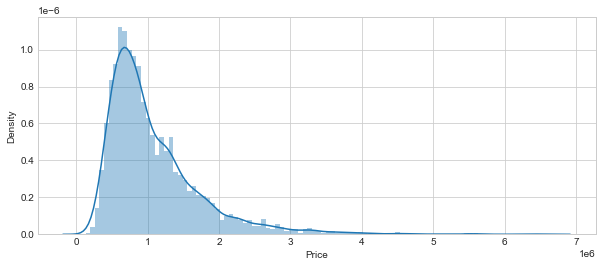

In [13]:
plt.figure(figsize=(10, 4))
sns.distplot(df.Price, bins=100)
plt.show()

Распределение средних цен по районам:

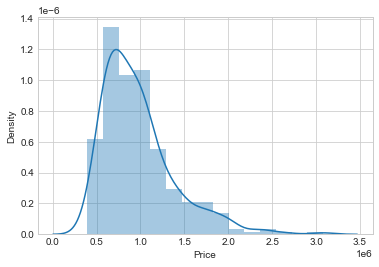

In [14]:
sns.distplot(districts[('Price', 'mean')], bins=15, axlabel='Price')
plt.show()

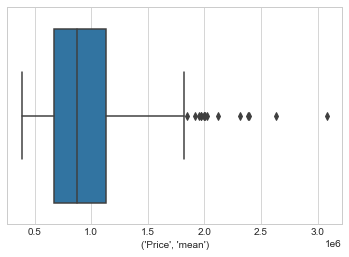

In [15]:
sns.boxplot(districts[('Price', 'mean')])
plt.show()

## Проверка на нормальность

In [16]:
def normal(samples, size):
    
    loc = samples.mean()
    scale = samples.std()

    plt.figure(figsize=(size, 4))
    plt.hist(samples, density=True, bins=100)

    x_left, x_right = plt.xlim()
    x = np.linspace(x_left, x_right, samples.shape[0])
    y = stats.norm.pdf(x, loc=loc, scale=scale)

    plt.plot(x, y, linestyle='dashed')
    plt.show()

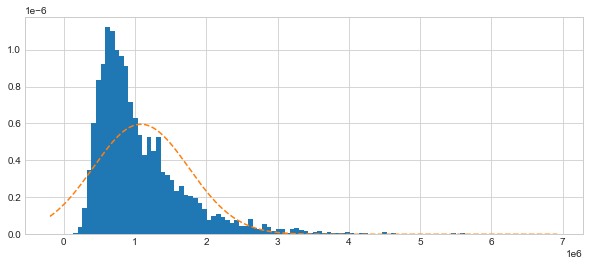

In [17]:
normal(df.Price, 10)

**Q-Q кривая:**

In [18]:
def QQ(samples):
    
    loc = samples.mean()
    scale = samples.std()

    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)

    plt.scatter(x, y, s=3)
    plt.plot(x, x, color='C1', linestyle='dashed')

    plt.xlabel('Теоретические квантили')
    plt.ylabel('Квантили выборки')
    plt.show()

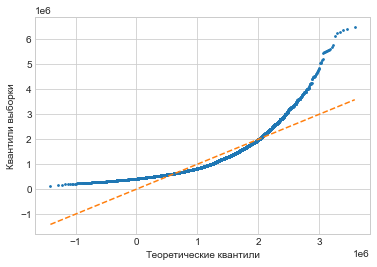

In [19]:
QQ(df.Price)

По форме плотность распределения цен похожа на нормальное, однако, логично, что пик плотности будет смещен к нижней границе, т.к. количество дешевых квартир на рынке существенно превышает количество дорогих. В связи с этим было бы интересным проанализировать плотность распределения стоимости квадратного метра, у которой тоже есть смещение, но менее выраженное:

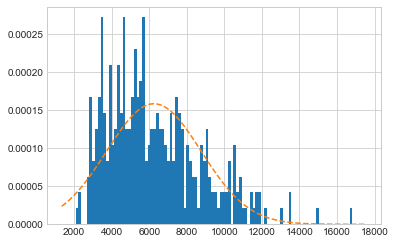

In [20]:
normal(districts[('Price', 'mean')] / districts[('BuildingArea', 'mean')], 6)      

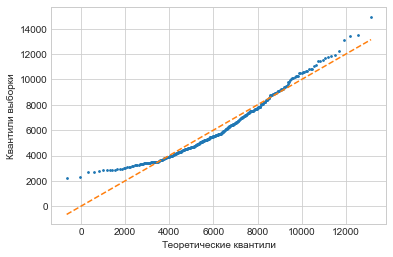

In [21]:
QQ(districts[('Price', 'mean')] / districts[('BuildingArea', 'mean')])

## Проверка статистических гипотез

Добавим в датасет информацию о стоимости квадратного метра:

In [22]:
df['Square meter price'] = df.Price / df.BuildingArea

In [23]:
districts = df.groupby('Suburb').agg({'Suburb': 'count', 'Distance': 'median', 'Price': ['mean', 'median', 'std'],\
                                     'BuildingArea': ['mean', 'median', 'std'], 'Square meter price': ['mean', 'median', 'std']\
                                     }).sort_values(by=('Square meter price', 'median'), ascending=False)

districts

Suburb Distance      Price                       BuildingArea  \
                count   median       mean     median        std         mean   
Suburb                                                                         
Middle Park        29     3.00 2629413.79 2250000.00 1603729.35       156.34   
Albert Park        35     3.30 1972957.14 1850000.00  863521.67       132.04   
Carlton North      20     3.20 1724300.00 1650000.00  831671.25       128.14   
East Melbourne      9     1.30 1514833.33 1300000.00 1252054.91       112.11   
Armadale           51     6.30 1714921.57 1435000.00 1286891.69       130.98   
...               ...      ...        ...        ...        ...          ...   
Eynesbury           1    29.80  700000.00  700000.00        nan       241.00   
Brookfield          3    29.80  479666.67  456000.00   50816.66       179.00   
Beaconsfield        1    39.00  670000.00  670000.00        nan       244.00   
Pakenham            8    47.30  508062.50  491500.00   69025.07       223.00   
Kurunjang          10    31.70  392100.00  377500.00   67513.70       146.20   

                             Square meter price                   
               median    std               mean   median     std  
Suburb                                                            
Middle Park    146.00  77.36           16495.58 16250.00 5135.86  
Albert Park    123.00  64.11           15512.05 14754.10 3327.41  
Carlton North  132.50  41.21           12942.22 13632.99 3674.25  
East Melbourne  92.00  79.69           13301.30 12900.00 2194.34  
Armadale       106.00  89.67           13071.88 12264.15 6820.59  
...               ...    ...                ...      ...     ...  
Eynesbury      241.00    nan            2904.56  2904.56     nan  
Brookfield     189.00  21.79            2691.83  2773.20  248.65  
Beaconsfield   244.00    nan            2745.90  2745.90     nan  
Pakenham       171.50 146.90            2936.82  2733.53 1306.96  
Kurunjang      139.50  29.57            2710.05  2654.76  288.90  

[324 rows x 11 columns]

Проверим нулевую гипотезу о том, что в пределах 5 км от центра Мельбурна средняя стоимость квадратного метра с уровнем значимости 5% равна 11.000 австралийских долларов.

Т.к. выборка стоимости квадратного метра распределена более-менее нормально, а среднее квадратическое отклонение неизвестно $\Rightarrow$ используем t-распределение Стьюдента:

$$t = \dfrac{\overline{X} - \mu}{\sigma_X / \sqrt{n}}$$

$$P \left( \overline{X} + t_{\alpha / 2, \: n - 1} \cdot \dfrac{\sigma_X}{\sqrt{n}} \leq \mu \leq \overline{X} + t_{1 - \alpha / 2, \: n - 1} \cdot \dfrac{\sigma_X}{\sqrt{n}} \right) = p$$

P-значение для двухсторонней области:

 $$\Omega_\alpha = \left( -\infty, t_{\alpha / 2} \right) \cup \left( t_{1 - \alpha / 2} , \infty \right)$$

$$P = 2 \cdot \min (P_l, P_r)$$

In [24]:
def hypothesis(samples, mu, alpha):
    
    mean = samples.mean()
    std = samples.std(ddof=1)
    n = samples.shape[0]
    
    t = (mean - mu) / (std / np.sqrt(n))
    t1 = stats.t.ppf(alpha / 2, df = n - 1)
    t2 = stats.t.ppf(1 - alpha / 2, df = n - 1)
    
    p_left = stats.t.cdf(t, df = n - 1)
    p_right = 1 - stats.t.cdf(t, df = n - 1)
    pvalue = 2 * min(p_left, p_right)
    
    ox = np.linspace(-4, 4, 1000)
    oy = stats.t.pdf(ox, df=n - 1)

    ox_left = np.linspace(-4, t1, 100)
    oy_left = stats.t.pdf(ox_left, df=n - 1)

    ox_right = np.linspace(t2, 4, 100)
    oy_right = stats.t.pdf(ox_right, df=n - 1)

    plt.plot(ox, oy)
    plt.scatter(t, 0, s=50, color='C3')
    plt.fill_between(ox_left, oy_left, alpha=0.5, color='C0')
    plt.fill_between(ox_right, oy_right, alpha=0.5, color='C0')

    return t1, t, t2, alpha < pvalue

(-1.9616807693696827, -2.254432013695166, 1.9616807693696823, False)

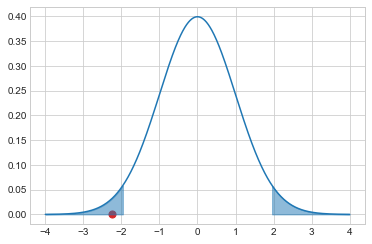

In [25]:
hypothesis(df.loc[df.Distance < 5, 'Square meter price'].values, 11000, 0.05)

При уровне значимости 5% нулевая гипотеза оказалась не верна, t-статистика попала в критическую область, а Р-значение оказалось меньше уровня значимости. Однако если возьмем в качестве нулевой гипотезы среднюю стоимость квадратного метра в 10.500 австралийских долларов при том же уровне значимости или оставим 11.000 австралийских долларов, но уровень значимости понизим до 1%, то гипотеза окажется верной:

(-1.9616807693696827, 1.0996396982776457, 1.9616807693696823, True)

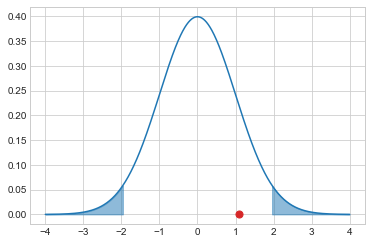

In [26]:
hypothesis(df.loc[df.Distance < 5, 'Square meter price'].values, 10500, 0.05)

(-2.579388914587805, -2.254432013695166, 2.5793889145878044, True)

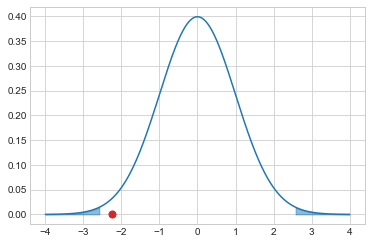

In [27]:
hypothesis(df.loc[df.Distance < 5, 'Square meter price'].values, 11000, 0.01)

## Корреляционный анализ

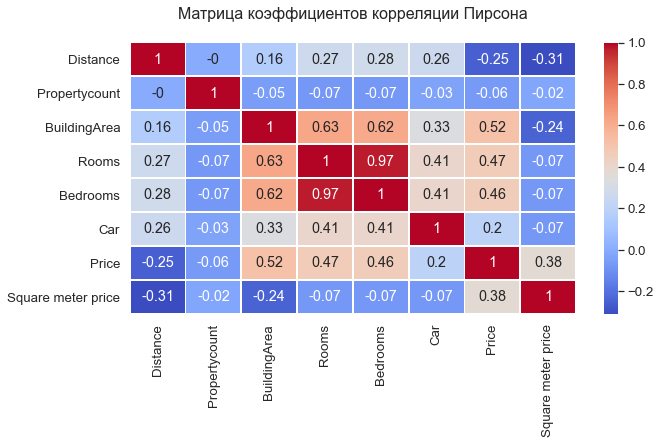

In [28]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(method='pearson').round(2), annot=True, linewidths=1, cmap='coolwarm')

plt.title('Матрица коэффициентов корреляции Пирсона\n', fontsize=16)
plt.show()

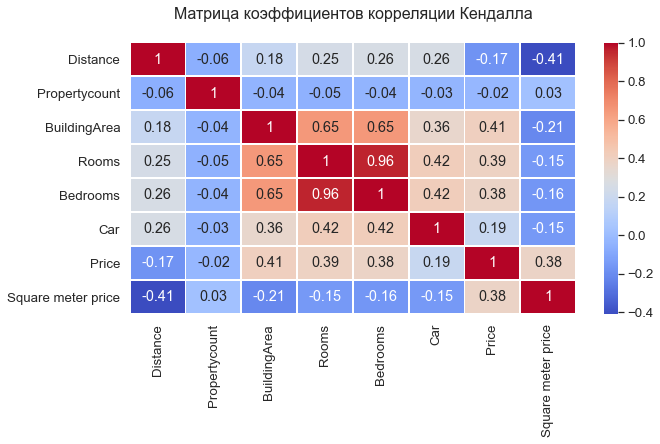

In [29]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(method='kendall').round(2), annot=True, linewidths=1, cmap='coolwarm')

plt.title('Матрица коэффициентов корреляции Кендалла\n', fontsize=16)
plt.show()

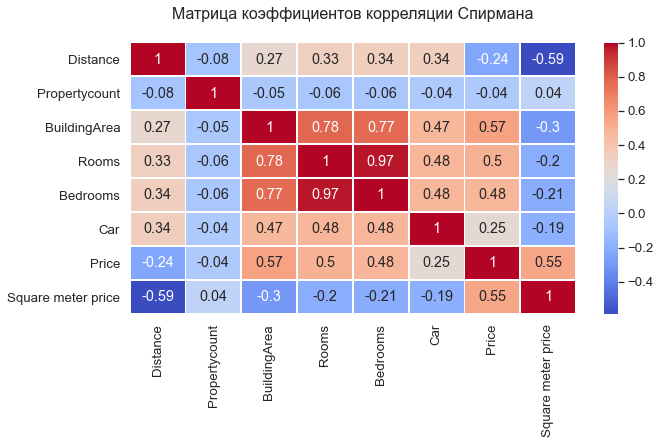

In [30]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(method='spearman').round(2), annot=True, linewidths=1, cmap='coolwarm')

plt.title('Матрица коэффициентов корреляции Спирмана\n', fontsize=16)
plt.show()

Все три метода корреляционного анализа показывают очень сильную зависимость между количеством комнат и спален, что достаточно логично. Также коэффициенты корреляции указывают на высокую обратную зависимость между расстоянием от центра города и стоимостью квадратного метра. Высокая корреляция наблюдается между количеством комнат, спален, площадью и ценой, а также между количеством комнат и машиномест, что тоже логично, т.к. в случае наличия машиноместа речь идет, вероятнее всего, не о кватире, а о доме, где заведомо комнат больше.

## Регрессионный анализ

Найдем уравнение парной регрессии вида $Y = aX + b$ между площадью и ценой объектов недвижимости в датасете:

$$a = \frac{\sigma_{XY}}{\sigma^2_X}$$

$$b = \overline{Y} - a \cdot {\overline{X}}$$

$$\sigma_{XY} = \dfrac{1}{n - 1} \displaystyle\sum_{i = 1}^n (x_i - \overline{X}) \cdot (y_i - \overline{Y})$$


In [31]:
def regression(X, Y, X_name, Y_name, top):

    cov = np.cov(X, Y)
    a = cov[0, 1] / cov[0, 0]
    b = np.mean(Y - a * X)

    plt.figure(figsize=(8, 8))

    sns.set_style('whitegrid')
    sns.scatterplot(X, Y, s=20)
    plt.plot(X, a * X + b, linestyle='dashed', color='C1')

    plt.xlabel(X_name)
    plt.ylabel(Y_name)
    plt.ylim(top=top)
    
    return f'Y = {a:.1f} * X + {b:.1f}'

'Y = 4069.5 * X + 461653.5'

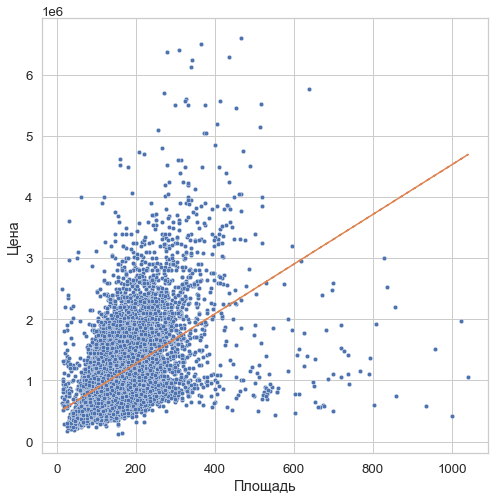

In [32]:
regression(df.BuildingArea, df.Price, 'Площадь', 'Цена', None)

Найдем также уравнение парной регрессии между хорошо скоррелированными расстоянием от центра города и стоимостью квадратного метра:

'Y = -239.9 * X + 10586.1'

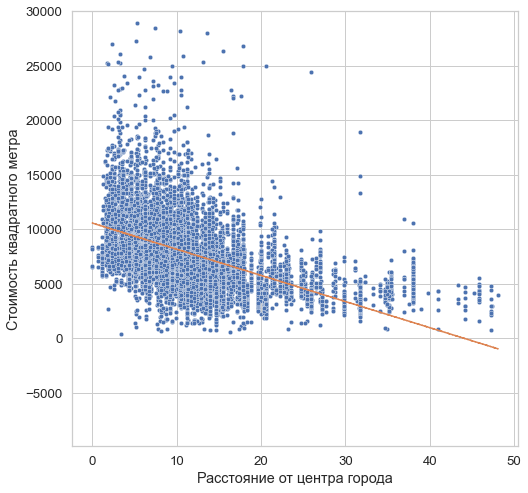

In [33]:
regression(df['Distance'], df['Square meter price'], 'Расстояние от центра города', 'Стоимость квадратного метра', 30000)

И сильно скоррелированными Rooms и Bedrooms:

'Y = 1.0 * X + 0.1'

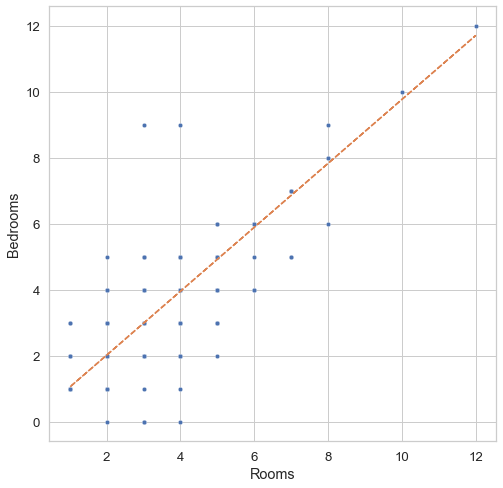

In [34]:
regression(df.Rooms, df.Bedrooms, 'Rooms', 'Bedrooms', None)

Найдем методом наименьших квадратов уравнение регрессии вида $y = b_0 + b_1 x_1 + \dots + b_m x_m + \varepsilon$, демонстрирующее зависимость цены объекта недвижимости от нескольких признаков. В качестве признаков возьмем расстояние от центра города, площадь объекта, количество комнат и машиномест, затем вычислим коэффициент детерминации:

$$b = (X^\top X)^{-1} X^\top Y$$

$$\varepsilon = y - x \cdot b$$

$$R^2 = 1 - \dfrac{D(\varepsilon)}{D(y)}$$

In [35]:
def R2_func(X, Y):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    XTX = X.T.dot(X)
    b = np.linalg.inv(XTX).dot(X.T).dot(Y)
    e = Y - X.dot(b)
    return 1 - e.var() / Y.var()

In [36]:
X = df[['Distance', 'BuildingArea', 'Rooms', 'Car']]
Y = df.Price

R2_func(X, Y)

0.45550612987950645

Оценим значимость получившегося уравнения регрессии с помощью F-теста Фишера:

$$F = \dfrac{R^2 / m}{(1 - R^2) / (n - m - 1)}$$

$$k_1 = m, k_2 = n - m - 1$$

$$\Omega_\alpha = \left( t_{1 - \alpha, \: k_1, k_2}, \infty \right)$$

In [37]:
def fisher(n, m, R2, alpha):
    
    k1 = m
    k2 = n - m - 1

    F = (R2 / k1) / ((1 - R2) / k2)
    t = stats.f.ppf(1 - alpha, k1, k2)
    
    ox = np.linspace(0, 5, 1000)
    oy = stats.f.pdf(ox, k1, k2)

    ox_right = np.linspace(t, 5, 1000)
    oy_right = stats.f.pdf(ox_right, k1, k2)

    plt.plot(ox, oy)
    plt.scatter(5.5, 0, s=50, color='C3') if F > 5.5 else plt.scatter(F, 0, s=50, color='C3')
    plt.fill_between(ox_right, oy_right, alpha=0.5)

    return f't = {t}, F = {F}'

't = 2.372791667488515, F = 2161.4824843036895'

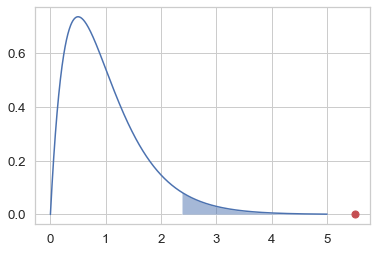

In [38]:
fisher(X.shape[0], X.shape[1], R2_func(X, Y), 0.05)

Cтатистика попадает в критическую область при уровне значимости 5% $\Rightarrow$ нулевая гипотеза отвергается, уравнение линейной регресcии признается значимым.

## Дисперсионный анализ

С помощью F-критерия Фишера проверим нулевую гипотезу о том, что во всех районах Мельбурна средние цены за квадратный метр не отличаются друг от друга:

$$SS_b = \displaystyle\sum_{i=1}^k \left( \overline{Y_i} - \overline{Y} \right)^2 n_i, \:\:
SS_w = \displaystyle\sum_{i=1}^k \displaystyle\sum_{j=1}^{n_i} \left( y_{ij} - \overline{Y_i} \right)^2,$$

$$\sigma_b^2 = \dfrac{SS_b}{k - 1}, \:\: \sigma_w^2 = \dfrac{SS_w}{n - k}$$

$$F = \dfrac{\sigma_b^2}{\sigma_w^2}$$

In [39]:
districts_data = df.groupby('Suburb').agg({'Square meter price': ['count', 'mean', 'var']})
districts_data.columns=('count', 'mean', 'var')

Заполним пропуски нулями, где дисперсия не определена из-за того, что в конкретном районе был продан только один объект недвижимости:

In [40]:
districts_data.loc[districts_data['var'].isna(), 'var'] = 0

In [41]:
districts_data

,count,mean,var
Suburb,,,
Abbotsford,44,12749.44,108069980.31
Aberfeldie,31,11968.65,174793581.99
Airport West,56,6115.08,10828341.14
Albanvale,5,4154.98,70834.39
Albert Park,35,15512.05,11071641.73
...,...,...,...
Wonga Park,2,5508.06,358388.46
Wyndham Vale,15,3450.63,538189.66
Yallambie,18,5213.92,666140.27


In [42]:
districts_mean = districts_data['mean'].mean()

SS_b = (pow((districts_data['mean'] - districts_mean), 2) * districts_data['count']).sum()
SS_w = districts_data['var'].sum()

SS_b, SS_w

(78412325549.57841, 5624926024.078346)

In [43]:
n = districts_data['count'].sum()
k = districts_data.shape[0]

k1 = k - 1
k2 = n - k

sigma2_b = SS_b / k1
sigma2_w = SS_w / k2

F = sigma2_b / sigma2_w

F

432.2741969373259

$$\Omega_\alpha = \left( t_{1 - \alpha, \: k_1, k_2}, \infty \right)$$

In [44]:
alpha = 0.05
t = stats.f.ppf(1 - alpha, k1, k2)

t

1.1353794689788141

In [45]:
F > t

True

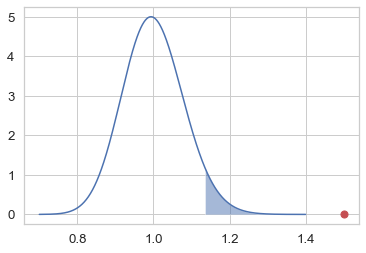

In [46]:
ox = np.linspace(0.7, 1.4, 1000)
oy = stats.f.pdf(ox, k1, k2)

ox_right = np.linspace(t, 1.4, 1000)
oy_right = stats.f.pdf(ox_right, k1, k2)

plt.plot(ox, oy)
plt.scatter(1.5, 0, s=50, color='C3') if F > 1.5 else plt.scatter(F, 0, s=50, color='C3')
plt.fill_between(ox_right, oy_right, alpha=0.5)
plt.show()

Cтатистика попадает в критическую область при уровне значимости 5% $\Rightarrow$ нулевая гипотеза отвергается, отличие средних цен за квадратный метр по районам является статистически значимым.

## Факторный анализ

Используя метод главных компонент, снизим количество признаков в датасете. Для этого возьмем два самые скоррелированные из них.

In [47]:
def pca(dataset):
    
    samples = np.array(dataset)
    
    samples_centered = samples - samples.mean(axis=0, keepdims=True)
    cov = np.cov(samples_centered.T, ddof=1)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    new_samples = samples_centered.dot(eigenvectors[:, [1]])

    variance_before = np.var(samples, axis=0, ddof=1).sum()
    variance_after = np.var(new_samples, axis=0, ddof=1).sum()
    
    sns.scatterplot(samples[:, 0], samples[:, 1])
    plt.show()
    
    return f'При объединении данных признаков сохранится {round(variance_after / variance_before * 100, 1)}% информации'

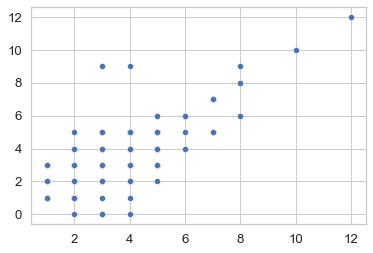

'При объединении данных признаков сохранится 98.4% информации'

In [48]:
pca(df[['Rooms', 'Bedrooms']])

Также в качестве примера возьмем менее коррелированные признаки - количество комнат и машиномест:

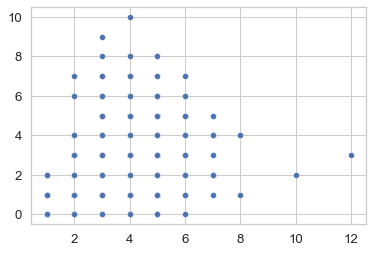

'При объединении данных признаков сохранится 70.3% информации'

In [49]:
pca(df[['Rooms', 'Car']])